In [1]:
# Intialization
import os
import sys

os.environ["SPARK_HOME"] = "/home/talentum/spark"
os.environ["PYLIB"] = os.environ["SPARK_HOME"] + "/python/lib"
# In below two lines, use /usr/bin/python2.7 if you want to use Python 2
os.environ["PYSPARK_PYTHON"] = "/usr/bin/python3.6" 
os.environ["PYSPARK_DRIVER_PYTHON"] = "/usr/bin/python3"
sys.path.insert(0, os.environ["PYLIB"] +"/py4j-0.10.7-src.zip")
sys.path.insert(0, os.environ["PYLIB"] +"/pyspark.zip")

# NOTE: Whichever package you want mention here.
# os.environ['PYSPARK_SUBMIT_ARGS'] = '--packages com.databricks:spark-xml_2.11:0.6.0 pyspark-shell' 
# os.environ['PYSPARK_SUBMIT_ARGS'] = '--packages org.apache.spark:spark-avro_2.11:2.4.0 pyspark-shell'
os.environ['PYSPARK_SUBMIT_ARGS'] = '--packages com.databricks:spark-xml_2.11:0.6.0,org.apache.spark:spark-avro_2.11:2.4.3 pyspark-shell'
# os.environ['PYSPARK_SUBMIT_ARGS'] = '--packages com.databricks:spark-xml_2.11:0.6.0,org.apache.spark:spark-avro_2.11:2.4.0 pyspark-shell'

In [2]:
from pyspark.sql import SparkSession

spark = SparkSession.builder.appName("Retail Demand Forecasting").enableHiveSupport().getOrCreate()
sc = spark.sparkContext

In [3]:
url = "jdbc:mysql://127.0.0.1:3306/test?useSSL=false&allowPublicKeyRetrieval=true"
driver = "com.mysql.jdbc.Driver"
user = "bigdata"
password = "Bigdata@123"

In [4]:
spark.sql("SHOW DATABASES").show()

+--------------------+
|        databaseName|
+--------------------+
|             default|
|       final_project|
|retail_demand_for...|
+--------------------+



In [5]:
spark.sql("USE retail_demand_forecasting")


DataFrame[]

In [6]:
product_df = spark.sql("SELECT * FROM product_data")
product_df.show(5)

+----------+--------------------+-------------+--------------------+--------------------+------------+
|       upc|         description| manufacturer|            category|        sub_category|product_size|
+----------+--------------------+-------------+--------------------+--------------------+------------+
|      null|         DESCRIPTION| MANUFACTURER|            CATEGORY|        SUB_CATEGORY|PRODUCT_SIZE|
|1111009477|PL MINI TWIST PRE...|PRIVATE LABEL|          BAG SNACKS|            PRETZELS|       15 OZ|
|1111009497|   PL PRETZEL STICKS|PRIVATE LABEL|          BAG SNACKS|            PRETZELS|       15 OZ|
|1111009507|   PL TWIST PRETZELS|PRIVATE LABEL|          BAG SNACKS|            PRETZELS|       15 OZ|
|1111038078|PL BL MINT ANTSPT...|PRIVATE LABEL|ORAL HYGIENE PROD...|MOUTHWASHES (ANTI...|      500 ML|
+----------+--------------------+-------------+--------------------+--------------------+------------+
only showing top 5 rows



In [7]:
store_df = spark.sql("select * from store_data")
store_df.show(5)

+--------+--------------+-----------------+-----------------------+--------+--------------+-----------------+------------------+
|store_id|    store_name|address_city_name|address_state_prov_code|msa_code|seg_value_name|parking_space_qty|avg_weekly_baskets|
+--------+--------------+-----------------+-----------------------+--------+--------------+-----------------+------------------+
|    null|    STORE_NAME|ADDRESS_CITY_NAME|   ADDRESS_STATE_PRO...|    null|SEG_VALUE_NAME|             null|              null|
|     367|15TH & MADISON|        COVINGTON|                     KY|   17140|         VALUE|              196|             24721|
|     389|    SILVERLAKE|         ERLANGER|                     KY|   17140|    MAINSTREAM|              408|             46073|
|     613|    EAST ALLEN|            ALLEN|                     TX|   19100|    MAINSTREAM|              464|             64926|
|     623|       HOUSTON|          HOUSTON|                     TX|   26420|    MAINSTREAM|      

In [8]:
train_df = spark.sql("select * from train_data")
train_df.show(5)

+-------------+---------+----------+----------+-------+-------+-----+
|week_end_date|store_num|       upc|base_price|feature|display|units|
+-------------+---------+----------+----------+-------+-------+-----+
|WEEK_END_DATE|     null|      null|      null|   null|   null| null|
|    14-Jan-09|      367|1111009477|      1.57|      0|      0|   13|
|    14-Jan-09|      367|1111009497|      1.39|      0|      0|   20|
|    14-Jan-09|      367|1111085319|      1.88|      0|      0|   14|
|    14-Jan-09|      367|1111085345|      1.88|      0|      0|   29|
+-------------+---------+----------+----------+-------+-------+-----+
only showing top 5 rows



In [9]:
product_df.printSchema()
store_df.printSchema()
train_df.printSchema()


root
 |-- upc: long (nullable = true)
 |-- description: string (nullable = true)
 |-- manufacturer: string (nullable = true)
 |-- category: string (nullable = true)
 |-- sub_category: string (nullable = true)
 |-- product_size: string (nullable = true)

root
 |-- store_id: long (nullable = true)
 |-- store_name: string (nullable = true)
 |-- address_city_name: string (nullable = true)
 |-- address_state_prov_code: string (nullable = true)
 |-- msa_code: long (nullable = true)
 |-- seg_value_name: string (nullable = true)
 |-- parking_space_qty: long (nullable = true)
 |-- avg_weekly_baskets: long (nullable = true)

root
 |-- week_end_date: string (nullable = true)
 |-- store_num: long (nullable = true)
 |-- upc: long (nullable = true)
 |-- base_price: double (nullable = true)
 |-- feature: integer (nullable = true)
 |-- display: integer (nullable = true)
 |-- units: long (nullable = true)



In [10]:
from pyspark.sql import functions as F

product_df_cleaned = product_df.filter(F.col("upc").isNotNull())

# Show the cleaned DataFrame
product_df_cleaned.show()

+----------+--------------------+-------------+--------------------+--------------------+------------+
|       upc|         description| manufacturer|            category|        sub_category|product_size|
+----------+--------------------+-------------+--------------------+--------------------+------------+
|1111009477|PL MINI TWIST PRE...|PRIVATE LABEL|          BAG SNACKS|            PRETZELS|       15 OZ|
|1111009497|   PL PRETZEL STICKS|PRIVATE LABEL|          BAG SNACKS|            PRETZELS|       15 OZ|
|1111009507|   PL TWIST PRETZELS|PRIVATE LABEL|          BAG SNACKS|            PRETZELS|       15 OZ|
|1111038078|PL BL MINT ANTSPT...|PRIVATE LABEL|ORAL HYGIENE PROD...|MOUTHWASHES (ANTI...|      500 ML|
|1111038080|PL ANTSPTC SPG MN...|PRIVATE LABEL|ORAL HYGIENE PROD...|MOUTHWASHES (ANTI...|      500 ML|
|1111085319|PL HONEY NUT TOAS...|PRIVATE LABEL|         COLD CEREAL|   ALL FAMILY CEREAL|    12.25 OZ|
|1111085345|      PL RAISIN BRAN|PRIVATE LABEL|         COLD CEREAL|     

In [11]:
store_df_cleaned = store_df.filter(F.col("store_id").isNotNull())
store_df_cleaned.show()


+--------+------------------+-----------------+-----------------------+--------+--------------+-----------------+------------------+
|store_id|        store_name|address_city_name|address_state_prov_code|msa_code|seg_value_name|parking_space_qty|avg_weekly_baskets|
+--------+------------------+-----------------+-----------------------+--------+--------------+-----------------+------------------+
|     367|    15TH & MADISON|        COVINGTON|                     KY|   17140|         VALUE|              196|             24721|
|     389|        SILVERLAKE|         ERLANGER|                     KY|   17140|    MAINSTREAM|              408|             46073|
|     613|        EAST ALLEN|            ALLEN|                     TX|   19100|    MAINSTREAM|              464|             64926|
|     623|           HOUSTON|          HOUSTON|                     TX|   26420|    MAINSTREAM|             null|             46930|
|    2277|ANDERSON TOWNE CTR|       CINCINNATI|                     O

In [12]:
train_df_cleaned = train_df.filter(F.col("week_end_date") != "WEEK_END_DATE")
train_df_cleaned.show()


+-------------+---------+----------+----------+-------+-------+-----+
|week_end_date|store_num|       upc|base_price|feature|display|units|
+-------------+---------+----------+----------+-------+-------+-----+
|    14-Jan-09|      367|1111009477|      1.57|      0|      0|   13|
|    14-Jan-09|      367|1111009497|      1.39|      0|      0|   20|
|    14-Jan-09|      367|1111085319|      1.88|      0|      0|   14|
|    14-Jan-09|      367|1111085345|      1.88|      0|      0|   29|
|    14-Jan-09|      367|1111085350|      1.98|      0|      0|   35|
|    14-Jan-09|      367|1111087395|      3.94|      0|      1|   50|
|    14-Jan-09|      367|1111087396|       4.0|      0|      1|   61|
|    14-Jan-09|      367|1111087398|       4.0|      0|      1|   72|
|    14-Jan-09|      367|1600027527|      3.19|      0|      0|   12|
|    14-Jan-09|      367|1600027528|      4.59|      0|      0|   31|
|    14-Jan-09|      367|1600027564|      3.07|      1|      0|   56|
|    14-Jan-09|     

Train data conatin following categorical features

    - STORE_NUM
    - UPC
    - FEATURE
    - DISPLAY


In [13]:
from pyspark.sql import functions as F

train_df_cleaned.select(
    F.sum(F.col('STORE_NUM').isNull().cast('int')).alias('STORE_NUM_nulls'),
    F.sum(F.col('UPC').isNull().cast('int')).alias('UPC_nulls'),
    F.sum(F.col('FEATURE').isNull().cast('int')).alias('FEATURE_nulls'),
    F.sum(F.col('DISPLAY').isNull().cast('int')).alias('DISPLAY_nulls')
).show()
#checking for null values in categorical features

+---------------+---------+-------------+-------------+
|STORE_NUM_nulls|UPC_nulls|FEATURE_nulls|DISPLAY_nulls|
+---------------+---------+-------------+-------------+
|              0|        0|            0|            0|
+---------------+---------+-------------+-------------+



train data has following nnumerical features
- BASE_PRICE
- UNITS (Target)

In [14]:
from pyspark.sql.functions import col, sum

train_df_cleaned.select(
    sum(col("BASE_PRICE").isNull().cast("int")).alias("BASE_PRICE_nulls"),
    sum(col("UNITS").isNull().cast("int")).alias("UNITS_nulls")
).show()


+----------------+-----------+
|BASE_PRICE_nulls|UNITS_nulls|
+----------------+-----------+
|              12|          0|
+----------------+-----------+



In [15]:
from pyspark.sql.functions import col, isnull

train_df_cleaned.filter(isnull(col("BASE_PRICE"))).show()


+-------------+---------+----------+----------+-------+-------+-----+
|week_end_date|store_num|       upc|base_price|feature|display|units|
+-------------+---------+----------+----------+-------+-------+-----+
|    14-Jan-09|     4245|1111087395|      null|      0|      1|   56|
|    14-Jan-09|     4245|1111087398|      null|      0|      1|   72|
|    14-Jan-09|     4259|1111087395|      null|      0|      1|   52|
|    14-Jan-09|     4259|1111087398|      null|      0|      1|   52|
|    21-Jan-09|     4245|1111087395|      null|      0|      1|   52|
|    21-Jan-09|     4245|1111087398|      null|      0|      1|   82|
|    21-Jan-09|     4259|1111087395|      null|      0|      1|   28|
|    28-Jan-09|     4245|1111087395|      null|      1|      1|   45|
|    28-Jan-09|     4245|1111087398|      null|      1|      1|   34|
|    28-Jan-09|     4259|1111087395|      null|      1|      1|   31|
|    04-Feb-09|     4245|1111087395|      null|      0|      1|   54|
|    04-Feb-09|     

In [16]:
#We have missing value in BASE_PRICE so impute the missing values with mean
from pyspark.sql.window import Window
from pyspark.sql.functions import avg, col, when

# Define a window partitioned by STORE_NUM
window_spec = Window.partitionBy("STORE_NUM")

# Calculate avg(BASE_PRICE) over the window and fill nulls
train_df_cleaned = train_df_cleaned.withColumn(
    "BASE_PRICE",
    when(
        col("BASE_PRICE").isNull(),
        avg("BASE_PRICE").over(window_spec)
    ).otherwise(col("BASE_PRICE"))
)



In [17]:
train_df_cleaned.filter(col("BASE_PRICE").isNull()).show()
# no null values

+-------------+---------+---+----------+-------+-------+-----+
|week_end_date|store_num|upc|BASE_PRICE|feature|display|units|
+-------------+---------+---+----------+-------+-------+-----+
+-------------+---------+---+----------+-------+-------+-----+



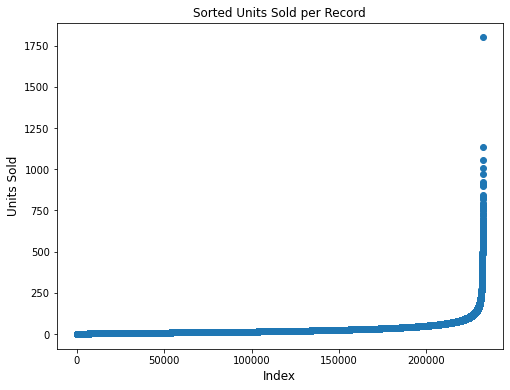

In [18]:
import matplotlib.pyplot as plt
import numpy as np

# Convert the PySpark DataFrame column to Pandas
units_pd = train_df_cleaned.select("UNITS").toPandas()

# Sort values
units_sorted = np.sort(units_pd['UNITS'].values)

# Plot
plt.figure(figsize=(8, 6))
plt.scatter(x=range(len(units_sorted)), y=units_sorted)
plt.xlabel('Index', fontsize=12)
plt.ylabel('Units Sold', fontsize=12)
plt.title('Sorted Units Sold per Record')
plt.show()


In [19]:
train_df_cleaned.filter(F.col("UNITS") > 750).count()
# only 21 units are > 750 so we will remove it

21

In [20]:
train_df_cleaned.filter(F.col("UNITS") > 750).select("UNITS").show()

+-----+
|UNITS|
+-----+
|  834|
|  796|
|  773|
|  925|
|  760|
|  899|
|  902|
|  833|
| 1006|
| 1800|
|  774|
| 1054|
| 1136|
|  843|
|  913|
|  755|
|  751|
|  823|
|  781|
|  819|
+-----+
only showing top 20 rows



In [21]:
train_df_cleaned = train_df_cleaned.filter(F.col("UNITS") <= 750)


In [22]:
train_df_cleaned.filter(F.col("UNITS") > 750).count()

0

In [24]:
updated_train_data = train_df_cleaned

In [26]:
updated_train_data.head(5)

[Row(week_end_date='14-Jan-09', store_num=367, upc=1111009477, BASE_PRICE=1.57, feature=0, display=0, units=13),
 Row(week_end_date='14-Jan-09', store_num=367, upc=1111009497, BASE_PRICE=1.39, feature=0, display=0, units=20),
 Row(week_end_date='14-Jan-09', store_num=367, upc=1111085319, BASE_PRICE=1.88, feature=0, display=0, units=14),
 Row(week_end_date='14-Jan-09', store_num=367, upc=1111085345, BASE_PRICE=1.88, feature=0, display=0, units=29),
 Row(week_end_date='14-Jan-09', store_num=367, upc=1111085350, BASE_PRICE=1.98, feature=0, display=0, units=35)]

PRODUCT DATA has the following categorical features
- UPC
- DESCRIPTION
- MANUFACTURER
- CATEGORY
- SUB_CATEGORY
- PRODUCT_SIZE

In [27]:
from pyspark.sql import functions as F

product_df_cleaned.select(
    F.sum(F.col('UPC').isNull().cast('int')).alias('UPC_nulls'),
    F.sum(F.col('DESCRIPTION').isNull().cast('int')).alias('DESCRIPTION_nulls'),
    F.sum(F.col('MANUFACTURER').isNull().cast('int')).alias('MANUFACTURER_nulls'),
    F.sum(F.col('CATEGORY').isNull().cast('int')).alias('CATEGORY_nulls'),
    F.sum(F.col('SUB_CATEGORY').isNull().cast('int')).alias('SUB_CATEGORY_nulls'),
    F.sum(F.col('PRODUCT_SIZE').isNull().cast('int')).alias('PRODUCT_SIZE_nulls')
).show()
#checking for null values in categorical features

+---------+-----------------+------------------+--------------+------------------+------------------+
|UPC_nulls|DESCRIPTION_nulls|MANUFACTURER_nulls|CATEGORY_nulls|SUB_CATEGORY_nulls|PRODUCT_SIZE_nulls|
+---------+-----------------+------------------+--------------+------------------+------------------+
|        0|                0|                 0|             0|                 0|                 0|
+---------+-----------------+------------------+--------------+------------------+------------------+



In [28]:
product_df_cleaned.select("DESCRIPTION").distinct().count()


29

In [29]:
# Unique MANUFACTURER count
product_df_cleaned.select("MANUFACTURER").distinct().count()

9

In [30]:

# Unique CATEGORY count
product_df_cleaned.select("CATEGORY").distinct().count()

4

In [31]:
# Unique SUB_CATEGORY count
product_df_cleaned.select("SUB_CATEGORY").distinct().count()

7

In [32]:
# Unique PRODUCT_SIZE count
product_df_cleaned.select("PRODUCT_SIZE").distinct().count()

16

DECSCRIPTION contain the information about category , subcategory and size which is already present so we will drop it

In [33]:
product_df_cleaned = product_df_cleaned.drop("DESCRIPTION")


In [34]:
product_df_cleaned.show(5)

+----------+-------------+--------------------+--------------------+------------+
|       upc| manufacturer|            category|        sub_category|product_size|
+----------+-------------+--------------------+--------------------+------------+
|1111009477|PRIVATE LABEL|          BAG SNACKS|            PRETZELS|       15 OZ|
|1111009497|PRIVATE LABEL|          BAG SNACKS|            PRETZELS|       15 OZ|
|1111009507|PRIVATE LABEL|          BAG SNACKS|            PRETZELS|       15 OZ|
|1111038078|PRIVATE LABEL|ORAL HYGIENE PROD...|MOUTHWASHES (ANTI...|      500 ML|
|1111038080|PRIVATE LABEL|ORAL HYGIENE PROD...|MOUTHWASHES (ANTI...|      500 ML|
+----------+-------------+--------------------+--------------------+------------+
only showing top 5 rows



In [35]:
from pyspark.sql.functions import split

product_df_cleaned = product_df_cleaned.withColumn("PRODUCT_SIZE", split("PRODUCT_SIZE", " ").getItem(0))


In [36]:
from pyspark.sql.functions import col

product_df_cleaned = product_df_cleaned.withColumn("PRODUCT_SIZE", col("PRODUCT_SIZE").cast("float"))


In [37]:
product_df_cleaned.printSchema()

root
 |-- upc: long (nullable = true)
 |-- manufacturer: string (nullable = true)
 |-- category: string (nullable = true)
 |-- sub_category: string (nullable = true)
 |-- PRODUCT_SIZE: float (nullable = true)



In [38]:
from pyspark.sql.functions import collect_set

product_df_cleaned.groupBy("CATEGORY") \
    .agg(collect_set("PRODUCT_SIZE").alias("unique_PRODUCT_SIZES")) \
    .show(truncate=False)


+---------------------+-------------------------------------+
|CATEGORY             |unique_PRODUCT_SIZES                 |
+---------------------+-------------------------------------+
|COLD CEREAL          |[12.0, 20.0, 12.25, 18.0, 12.2, 15.0]|
|FROZEN PIZZA         |[29.6, 28.3, 30.5, 29.8, 32.7, 22.7] |
|ORAL HYGIENE PRODUCTS|[1.0, 500.0]                         |
|BAG SNACKS           |[10.0, 16.0, 15.0]                   |
+---------------------+-------------------------------------+



ORAL HYGIENE PRODUCTS comes in two size 500 ml and 1 L , converting then to oz as other products

In [39]:
product_df_cleaned.filter(product_df_cleaned.PRODUCT_SIZE == 500.0).show()


+----------+-------------+--------------------+--------------------+------------+
|       upc| manufacturer|            category|        sub_category|PRODUCT_SIZE|
+----------+-------------+--------------------+--------------------+------------+
|1111038078|PRIVATE LABEL|ORAL HYGIENE PROD...|MOUTHWASHES (ANTI...|       500.0|
|1111038080|PRIVATE LABEL|ORAL HYGIENE PROD...|MOUTHWASHES (ANTI...|       500.0|
+----------+-------------+--------------------+--------------------+------------+



In [40]:
product_df_cleaned.filter(product_df_cleaned.PRODUCT_SIZE == 1.0).show()

+-----------+------------+--------------------+--------------------+------------+
|        upc|manufacturer|            category|        sub_category|PRODUCT_SIZE|
+-----------+------------+--------------------+--------------------+------------+
| 3700031613|       P & G|ORAL HYGIENE PROD...|MOUTHWASH/RINSES ...|         1.0|
| 3700044982|       P & G|ORAL HYGIENE PROD...|MOUTHWASHES (ANTI...|         1.0|
|31254742735|      WARNER|ORAL HYGIENE PROD...|MOUTHWASHES (ANTI...|         1.0|
|31254742835|      WARNER|ORAL HYGIENE PROD...|MOUTHWASHES (ANTI...|         1.0|
+-----------+------------+--------------------+--------------------+------------+



In [41]:
product_df_cleaned = product_df_cleaned.replace({500.00: 17.00, 1.00: 34.00}, subset=["PRODUCT_SIZE"])


In [42]:
product_df_cleaned.filter(col("PRODUCT_SIZE").isin(17.00, 34.00)).show()


+-----------+-------------+--------------------+--------------------+------------+
|        upc| manufacturer|            category|        sub_category|PRODUCT_SIZE|
+-----------+-------------+--------------------+--------------------+------------+
| 1111038078|PRIVATE LABEL|ORAL HYGIENE PROD...|MOUTHWASHES (ANTI...|        17.0|
| 1111038080|PRIVATE LABEL|ORAL HYGIENE PROD...|MOUTHWASHES (ANTI...|        17.0|
| 3700031613|        P & G|ORAL HYGIENE PROD...|MOUTHWASH/RINSES ...|        34.0|
| 3700044982|        P & G|ORAL HYGIENE PROD...|MOUTHWASHES (ANTI...|        34.0|
|31254742735|       WARNER|ORAL HYGIENE PROD...|MOUTHWASHES (ANTI...|        34.0|
|31254742835|       WARNER|ORAL HYGIENE PROD...|MOUTHWASHES (ANTI...|        34.0|
+-----------+-------------+--------------------+--------------------+------------+



In [43]:
import pandas as pd

In [44]:
product = product_df_cleaned.toPandas()

In [45]:
print(product.head())

          upc   manufacturer               category              sub_category  \
0  1111009477  PRIVATE LABEL             BAG SNACKS                  PRETZELS   
1  1111009497  PRIVATE LABEL             BAG SNACKS                  PRETZELS   
2  1111009507  PRIVATE LABEL             BAG SNACKS                  PRETZELS   
3  1111038078  PRIVATE LABEL  ORAL HYGIENE PRODUCTS  MOUTHWASHES (ANTISEPTIC)   
4  1111038080  PRIVATE LABEL  ORAL HYGIENE PRODUCTS  MOUTHWASHES (ANTISEPTIC)   

   PRODUCT_SIZE  
0          15.0  
1          15.0  
2          15.0  
3          17.0  
4          17.0  


In [46]:
product_ohe = pd.get_dummies(product)

In [47]:
product_ohe.head()

,upc,PRODUCT_SIZE,manufacturer_FRITO LAY,manufacturer_GENERAL MI,manufacturer_KELLOGG,manufacturer_P & G,manufacturer_PRIVATE LABEL,manufacturer_SNYDER S,manufacturer_TOMBSTONE,manufacturer_TONYS,...,category_COLD CEREAL,category_FROZEN PIZZA,category_ORAL HYGIENE PRODUCTS,sub_category_ADULT CEREAL,sub_category_ALL FAMILY CEREAL,sub_category_KIDS CEREAL,sub_category_MOUTHWASH/RINSES AND SPRAYS,sub_category_MOUTHWASHES (ANTISEPTIC),sub_category_PIZZA/PREMIUM,sub_category_PRETZELS
0,1111009477,15.0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,1
1,1111009497,15.0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,1
2,1111009507,15.0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,1
3,1111038078,17.0,0,0,0,0,1,0,0,0,...,0,0,1,0,0,0,0,1,0,0
4,1111038080,17.0,0,0,0,0,1,0,0,0,...,0,0,1,0,0,0,0,1,0,0


In [48]:
updated_product_data = product_ohe

In [49]:
updated_product_data.head()

,upc,PRODUCT_SIZE,manufacturer_FRITO LAY,manufacturer_GENERAL MI,manufacturer_KELLOGG,manufacturer_P & G,manufacturer_PRIVATE LABEL,manufacturer_SNYDER S,manufacturer_TOMBSTONE,manufacturer_TONYS,...,category_COLD CEREAL,category_FROZEN PIZZA,category_ORAL HYGIENE PRODUCTS,sub_category_ADULT CEREAL,sub_category_ALL FAMILY CEREAL,sub_category_KIDS CEREAL,sub_category_MOUTHWASH/RINSES AND SPRAYS,sub_category_MOUTHWASHES (ANTISEPTIC),sub_category_PIZZA/PREMIUM,sub_category_PRETZELS
0,1111009477,15.0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,1
1,1111009497,15.0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,1
2,1111009507,15.0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,1
3,1111038078,17.0,0,0,0,0,1,0,0,0,...,0,0,1,0,0,0,0,1,0,0
4,1111038080,17.0,0,0,0,0,1,0,0,0,...,0,0,1,0,0,0,0,1,0,0


STORE DATA has the following categorical features
- STORE_ID
- STORE_NAME
- ADDRESS_CITY_NAME
- ADDRESS_STATE_PROV_CODE
- MSA_CODE
- SEG_VALUE_NAME

In [50]:
from pyspark.sql import functions as F

store_df_cleaned.select(
    F.sum(F.col('STORE_ID').isNull().cast('int')).alias('STORE_ID_nulls'),
    F.sum(F.col('STORE_NAME').isNull().cast('int')).alias('STORE_NAME_nulls'),
    F.sum(F.col('ADDRESS_CITY_NAME').isNull().cast('int')).alias('ADDRESS_CITY_NAME_nulls'),
    F.sum(F.col('ADDRESS_STATE_PROV_CODE').isNull().cast('int')).alias('ADDRESS_STATE_PROV_CODE_nulls'),
    F.sum(F.col('MSA_CODE').isNull().cast('int')).alias('MSA_CODE_nulls'),
    F.sum(F.col('SEG_VALUE_NAME').isNull().cast('int')).alias('SEG_VALUE_NAME_nulls')
).show()


+--------------+----------------+-----------------------+-----------------------------+--------------+--------------------+
|STORE_ID_nulls|STORE_NAME_nulls|ADDRESS_CITY_NAME_nulls|ADDRESS_STATE_PROV_CODE_nulls|MSA_CODE_nulls|SEG_VALUE_NAME_nulls|
+--------------+----------------+-----------------------+-----------------------------+--------------+--------------------+
|             0|               0|                      0|                            0|             0|                   0|
+--------------+----------------+-----------------------+-----------------------------+--------------+--------------------+



In [51]:
store_df_cleaned.select("STORE_NAME").distinct().count()


72

In [52]:
store_df_cleaned.select("ADDRESS_CITY_NAME").distinct().count()

51

In [53]:
store_df_cleaned.select("ADDRESS_STATE_PROV_CODE").distinct().count()

4

In [54]:
store_df_cleaned.select("MSA_CODE").distinct().count()

9

In [55]:
store_df_cleaned.select("SEG_VALUE_NAME").distinct().count()

3

In [56]:
store_df_cleaned = store_df_cleaned.drop('STORE_NAME', 'ADDRESS_CITY_NAME')
# drop due to high cardinality

In [57]:
from pyspark.sql.functions import when, col

store_df_cleaned = store_df_cleaned.withColumn(
    "SEG_VALUE_NAME",
    when(col("SEG_VALUE_NAME") == "VALUE", 1)
    .when(col("SEG_VALUE_NAME") == "MAINSTREAM", 2)
    .when(col("SEG_VALUE_NAME") == "UPSCALE", 3)
)


STORE DATA has the following numerical features

    PARKING_SPACE_QTY
    SALES_AREA_SIZE_NUM
    AVG_WEEKLY_BASKETS



In [58]:
store_df_cleaned.printSchema()


root
 |-- store_id: long (nullable = true)
 |-- address_state_prov_code: string (nullable = true)
 |-- msa_code: long (nullable = true)
 |-- SEG_VALUE_NAME: integer (nullable = true)
 |-- parking_space_qty: long (nullable = true)
 |-- avg_weekly_baskets: long (nullable = true)



In [59]:
store_df_cleaned.columns


['store_id',
 'address_state_prov_code',
 'msa_code',
 'SEG_VALUE_NAME',
 'parking_space_qty',
 'avg_weekly_baskets']

In [60]:
store_df_cleaned = store_df_cleaned.drop('PARKING_SPACE_QTY')

In [61]:

store_df_cleaned.columns

['store_id',
 'address_state_prov_code',
 'msa_code',
 'SEG_VALUE_NAME',
 'avg_weekly_baskets']

In [62]:
store = store_df_cleaned.toPandas()

In [63]:
store = pd.get_dummies(store)

In [64]:
store.head()

,store_id,msa_code,SEG_VALUE_NAME,avg_weekly_baskets,address_state_prov_code_IN,address_state_prov_code_KY,address_state_prov_code_OH,address_state_prov_code_TX
0,367,17140,1,24721,0,1,0,0
1,389,17140,2,46073,0,1,0,0
2,613,19100,2,64926,0,0,0,1
3,623,26420,2,46930,0,0,0,1
4,2277,17140,3,81958,0,0,1,0


In [65]:
updated_store_data = store

In [66]:
updated_store_data.head()

,store_id,msa_code,SEG_VALUE_NAME,avg_weekly_baskets,address_state_prov_code_IN,address_state_prov_code_KY,address_state_prov_code_OH,address_state_prov_code_TX
0,367,17140,1,24721,0,1,0,0
1,389,17140,2,46073,0,1,0,0
2,613,19100,2,64926,0,0,0,1
3,623,26420,2,46930,0,0,0,1
4,2277,17140,3,81958,0,0,1,0


In [70]:
updated_train_data = updated_train_data.toPandas()

In [71]:
updated_train_data.head()

,week_end_date,store_num,upc,BASE_PRICE,feature,display,units
0,14-Jan-09,367,1111009477,1.57,0,0,13
1,14-Jan-09,367,1111009497,1.39,0,0,20
2,14-Jan-09,367,1111085319,1.88,0,0,14
3,14-Jan-09,367,1111085345,1.88,0,0,29
4,14-Jan-09,367,1111085350,1.98,0,0,35


In [72]:
updated_train_data.to_csv('/home/talentum/updated_train_data.csv', index=False)

In [68]:
updated_store_data.to_csv('/home/talentum/updated_store_data.csv', index=False)

In [69]:
updated_product_data.to_csv('/home/talentum/updated_product_data.csv', index=False)